## Data aggregation

In [1]:
# Import python basics
import re

# Imports for database
from bs4 import BeautifulSoup
import psycopg2
import config

In [2]:
def convert_question_for_db(row):
    if (row['posttypeid'] == 2):
        return None
    result = []
    try:
        result.append(row['id'])
        result.append(row['posttypeid'])
        result.append(row['acceptedanswerid'])
        result.append(row['creationdate'])
        result.append(row['score'])
        result.append(row['viewcount'])
        result.append(row['body'])
        result.append(row['owneruserid'])
        result.append(row['title'])
        result.append(row['tags'])
        result.append(row['answercount'])
        result.append(row['commentcount'])
        result.append(row['favoritecount'])
    except(KeyError):
        return None
    return result

def insert_one_by_one(list, db):
    sql = ""
    if db == "questions":
        sql = "INSERT INTO questions VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);"
    elif db == "answers":
        sql = "INSERT INTO answers VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);"
    elif db == "new_questions":
        sql = "INSERT INTO new_questions VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s);"
    conn = None
    error_count = 0
    upload_count = 0
    try:
        # connect
        conn = psycopg2.connect("dbname=" +config.database['dbname'] +" user=" +config.database['user'] +" password=" +config.database['password'])
        cur = conn.cursor()
        
        # execute every object in list one by one
        for object in list:
            try:
                cur.execute(sql, object)
                conn.commit()
                upload_count += 1
            except(psycopg2.DatabaseError) as error:
                conn.rollback()
                error_count += 1
                
        # close
        cur.close()
        
        print(str(upload_count) +" items uploaded and " +str(error_count) +" skipped.")
        
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error @ insert_one_by_one")
        print(error)
    finally:
        if conn is not None:
            conn.close()

def upload_question(limit, tag, db):
    with open("Data-Dump/Posts.xml", encoding='utf-8') as file:
        found = 0
        db_list = []
        for line in file:
            if ('PostTypeId="1"' in line and tag in line):
                souped = BeautifulSoup(line)
                if (souped.row is not None):
                    result = souped.find_all("row", {'tags': re.compile("(<" +tag +">)")})
                    if (len(result) > 0):
                        dbobject = convert_question_for_db(souped.row)
                        if (dbobject is not None):
                            db_list.append(dbobject)
                            found += 1
                            if (found%10000 == 0):
                                print(str(found) +" entries found.")
            if (found == limit):
                break
        print(str(found) +" entries found overall.")
        print("Now uploading...")
        insert_one_by_one(db_list, db)

### Uploading the questions to work with

In [ ]:
upload_question(50000, "java", "questions")
upload_question(50337, "python", "questions") #because 337 questions were tagged with 'python' and 'java'

### Uploading the corresponding accepted answers

In [3]:
def convert_answers_for_db(row):
    if (row['posttypeid'] == 1):
        return None
    result = []
    try:
        result.append(row['id'])
        result.append(row['posttypeid'])
        result.append(row['parentid'])
        result.append(row['creationdate'])
        result.append(row['score'])
        result.append(999)
        result.append(row['body'])
        result.append(999)
        result.append(" ")
        result.append(" ")
        result.append(0)
        result.append(row['commentcount'])
        result.append(999)
    except(KeyError):
        return None
    return result

def get_questions(data):
    sql = ""
    if data == "training":
        sql = """select * from questions"""
    elif data == "testing":
        sql = """select * from new_questions"""
    
    conn = None
    error_count = 0
    upload_count = 0
    try:
        # connect
        conn = psycopg2.connect("dbname=" +config.database['dbname'] +" user=" +config.database['user'] +" password=" +config.database['password'])
        cur = conn.cursor()

        # get all records
        cur.execute(sql)
        questions = cur.fetchall()

        # close
        cur.close()

    except (Exception, psycopg2.DatabaseError) as error:
        print("Error @ returning all questions")
        print(error)
    finally:
        if conn is not None:
            conn.close()
    print("returned " +str(len(questions)) +" items in list.")
    results = sorted(questions, key=lambda x: x[2])
    return results

def upload_corresponding_answers(questions):
    question_ids = []
    for question in questions:
        question_ids.append(' Id="' +str(question[2]) +'"')
    db_list = []
    found = 0
    current_index = 0
    unfound_items = []
    with open("Data-Dump/Posts.xml", encoding='utf-8') as file:
        for line in file:
#             if any(s in line for s in question_ids):
            if (question_ids[current_index] in line):
                current_index += 1
                souped = BeautifulSoup(line)
                if (souped.row is not None):
                    dbobject = convert_answers_for_db(souped.row)
                    if (dbobject is not None):
                        db_list.append(dbobject)
                        found += 1
                if (found%10000 == 0):
                    print(str(found) +" entries found.")
            elif (len(question_ids) >= current_index+1 and question_ids[current_index+1] in line):
                unfound_items.append(question_ids[current_index])
                current_index += 2
                souped = BeautifulSoup(line)
                if (souped.row is not None):
                    dbobject = convert_answers_for_db(souped.row)
                    if (dbobject is not None):
                        db_list.append(dbobject)
                        found += 1
                if (found%10000 == 0):
                    print(str(found) +" entries found.")
            elif (len(question_ids) >= current_index+2 and question_ids[current_index+2] in line):
                unfound_items.append(question_ids[current_index])
                unfound_items.append(question_ids[current_index+1])
                current_index += 3
                souped = BeautifulSoup(line)
                if (souped.row is not None):
                    dbobject = convert_answers_for_db(souped.row)
                    if (dbobject is not None):
                        db_list.append(dbobject)
                        found += 1
                if (found%10000 == 0):
                    print(str(found) +" entries found.")
            if (found == 90000):
                break
        print("Those items were not in the data set: ", unfound_items)
        print(str(found) +" entries found overall.")
        print("Now uploading...")
        insert_one_by_one(db_list, "answers")

In [ ]:
upload_corresponding_answers(get_questions("training"))

## Doc2Vec implementation

In [4]:
# Imports
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [5]:
def get_question_titles():
    raw_data = get_questions("training")
    result = []
    for record in raw_data:
        result.append(record[8])
    return result

def display_first(sim_doc, count):
    for i in range (count):
        print(sim_doc[i][1], " ", tagged_data[int(sim_doc[i][0])][0])
    print("\n")

In [ ]:
# calculate average words per title
data = get_question_titles()
cumulative_words = 0

for record in data:
    splitted = record.split(" ")
    cumulative_words += len(splitted)

print("average words per title ", cumulative_words/(len(data)))

In [ ]:
# count all used words
counter = 0

for record in tagged_data:
    counter += len(record.words)
    
print(counter)

In [6]:
data = get_question_titles()
data_filtered = []
stop_words = set(stopwords.words('english'))
additional_stop_words = ("? : ( ) ; , `` - 's '").lower().split(" ")
for w in additional_stop_words:
    stop_words.add(w)

for record in data:
    tokenized = word_tokenize(record.lower())
    data_filtered.append([w for w in tokenized if not w in stop_words])

tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data_filtered)]

returned 100000 items in list.


In [ ]:
# create models
manual = [24,100,300,100,1000,100]

for i in range(int(len(manual)/2)):
    alpha = 0.025

    model = Doc2Vec(vector_size=manual[i*2],
                    alpha=alpha,
                    min_alpha=0.00025,
                    min_count=2,
                    workers=6,
                    dm =1)

    model.build_vocab(tagged_data)

    for epoch in range(manual[(i*2)+1]):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("2020-07-01_vec"+str(manual[(i*2)])+"epoch"+str(manual[(i*2)+1])+".model")
    print("2020-07-01_vec"+str(manual[(i*2)])+"epoch"+str(manual[(i*2)+1])+".model saved \n")

### semantic clustering

In [7]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from heapq import nlargest
from operator import itemgetter

In [8]:
def get_keywords_from_cluster(cluster_df):
    dict = {}
    for i in range(len(cluster_df)):
        record = tagged_data[cluster_df["index"].iloc[i]][0]
        for j in range(len(record)):
            if record[j] not in dict:
                dict[record[j]] = 1
            else:
                dict[record[j]] += 1
    return dict

def fill_resulttable(length, df_0, df_1, df_2):
    result_df = pd.DataFrame()
    
    result_0 = pd.DataFrame(columns=["df_0_name", "df_0_value"])
    for name, value in nlargest(length, get_keywords_from_cluster(df_0).items(), key=itemgetter(1)):
        result_0 = result_0.append({'df_0_name': name, 'df_0_value': value}, ignore_index = True)
    
    result_1 = pd.DataFrame(columns=["df_1_name", "df_1_value"])
    for name, value in nlargest(length, get_keywords_from_cluster(df_1).items(), key=itemgetter(1)):
        result_1 = result_1.append({'df_1_name': name, 'df_1_value': value}, ignore_index = True)
    
    result_2 = pd.DataFrame(columns=["df_2_name", "df_2_value"])
    for name, value in nlargest(length, get_keywords_from_cluster(df_2).items(), key=itemgetter(1)):
        result_2 = result_2.append({'df_2_name': name, 'df_2_value': value}, ignore_index = True)
    
    result_df = pd.concat([result_df, result_0, result_1, result_2], axis=1)    
    return result_df


#### dimension 24

In [9]:
print("2020-06-26_vec24epoch100")
doc2vec_model = Doc2Vec.load("2020-06-26_vec24epoch100.model")

2020-06-26_vec24epoch100


In [10]:
doc2vec_model_kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 

doc2vec_model_kmeans_model.fit(doc2vec_model.docvecs.vectors_docs)
labels = doc2vec_model_kmeans_model.labels_.tolist()
doc2vec_model_kmeans_model.fit_predict(doc2vec_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(doc2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(doc2vec_model.docvecs.vectors_docs)

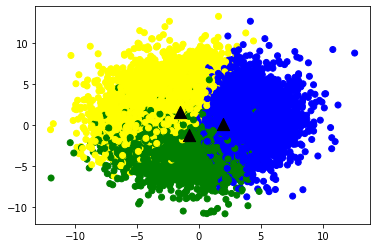

In [11]:
%matplotlib inline
plt.figure
colors = ["#FFFF00", "#008000", "#0000FF", "#454DFF", "#D56F4F", "#FEFFF5"]
color = [colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = doc2vec_model_kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

#### dimension 300

In [12]:
print("2020-06-26_vec300epoch100")
doc2vec_model = Doc2Vec.load("2020-06-26_vec300epoch100.model")

2020-06-26_vec300epoch100


In [13]:
doc2vec_model_kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 

doc2vec_model_kmeans_model.fit(doc2vec_model.docvecs.vectors_docs)
labels = doc2vec_model_kmeans_model.labels_.tolist()
doc2vec_model_kmeans_model.fit_predict(doc2vec_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(doc2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(doc2vec_model.docvecs.vectors_docs)

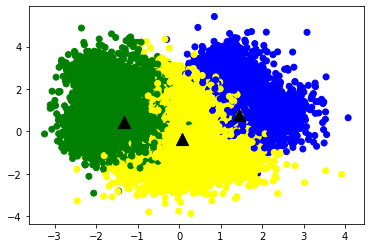

In [14]:
%matplotlib inline
plt.figure
colors = ["#FFFF00", "#008000", "#0000FF", "#454DFF", "#D56F4F", "#FEFFF5"]
color = [colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = doc2vec_model_kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

#### dimension 1000

In [15]:
print("2020-06-26_vec1000epoch100")
doc2vec_model = Doc2Vec.load("2020-06-26_vec1000epoch100.model")

2020-06-26_vec1000epoch100


In [16]:
doc2vec_model_kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 

doc2vec_model_kmeans_model.fit(doc2vec_model.docvecs.vectors_docs)
labels = doc2vec_model_kmeans_model.labels_.tolist()
doc2vec_model_kmeans_model.fit_predict(doc2vec_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(doc2vec_model.docvecs.vectors_docs)
datapoint = pca.transform(doc2vec_model.docvecs.vectors_docs)

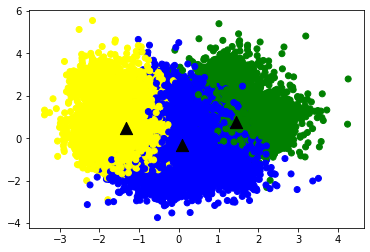

In [17]:
%matplotlib inline
plt.figure
colors = ["#FFFF00", "#008000", "#0000FF", "#454DFF", "#D56F4F", "#FEFFF5"]
color = [colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = doc2vec_model_kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

### topic generation

In [18]:
def get_labels(model):
    doc2vec_model = Doc2Vec.load(model)    
    doc2vec_model_kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 
    doc2vec_model_kmeans_model.fit(doc2vec_model.docvecs.vectors_docs)
    labels = doc2vec_model_kmeans_model.labels_.tolist()
    return labels

def generate_topics(labels):
    print("-------------------------------------------")
    label_df = pd.DataFrame(labels, columns=["label"])
    label_df['index'] = np.arange(len(label_df))

    # dataframes for every cluster
    df_0 = pd.DataFrame(label_df[label_df["label"] == 0]["index"])
    df_1 = pd.DataFrame(label_df[label_df["label"] == 1]["index"])
    df_2 = pd.DataFrame(label_df[label_df["label"] == 2]["index"])
    
    table = fill_resulttable(100, df_0, df_1, df_2)
    print(table,"\n")
    
    # check common 100 words against other cluster and return differences or unique topics
    common_words = []
    common_words.append([])
    common_words.append([])
    common_words.append([])

    for j in range(3):
        for i in range(100):
            common_words[j].append(table.loc[i][j*2])
            for k in range(100):
                if table.loc[i][j*2] == table.loc[k][0] and j*2 != 0:
                    del common_words[j][-1]
                    break
                elif table.loc[i][j*2] == table.loc[k][2] and j*2 != 2:
                    del common_words[j][-1]
                    break
                elif table.loc[i][j*2] == table.loc[k][4] and j*2 != 4:
                    del common_words[j][-1]
                    break

    common_words_df = pd.DataFrame(common_words).transpose()
    print(common_words_df)
    return common_words_df

In [19]:
topic24 = generate_topics(get_labels("2020-06-26_vec24epoch100.model"))
topic300 = generate_topics(get_labels("2020-06-26_vec300epoch100.model"))
topic1000 = generate_topics(get_labels("2020-06-26_vec1000epoch100.model"))

-------------------------------------------
   df_0_name df_0_value df_1_name df_1_value   df_2_name df_2_value
0     python       8220    python       6015      python       9708
1       java       6317      java       4579        java       6907
2       file       1993     using       2471       using       2787
3      using       1839    django       1223        file       1765
4     django       1601   without       1075      string       1743
..       ...        ...       ...        ...         ...        ...
95     first        251  database        229    database        284
96   logging        251    number        229  connection        281
97   command        248   classes        227        time        279
98     query        244   strings        224     install        277
99       jsp        243    client        221   directory        273

[100 rows x 6 columns] 

             0          1               2
0          xml    without      equivalent
1         name    problem     

0: theoretical/logical questions, 

1: practical questions concerning implementation,

2: questions concerning libraries, transfer knowledge

### answering new questions

similarity requests of the answers for semantically close questions

search in database for questions which are matching >95% and conclude wether the given answers can answer the question

In [ ]:
#uploading 10.000 new questions for both tags
upload_question(60000, "java", "new_questions")
upload_question(60381, "python", "new_questions")

#### forward search

In [20]:
doc2vec_model = Doc2Vec.load("2020-06-26_vec24epoch100.model")
testing_questions = get_questions("testing")
high_matches = []
high_matches.append([])
high_matches.append([])
counter = 0
for record in testing_questions:
    counter += 1
    if counter%5000 == 0:
        print(counter, "reached.")
    infer = doc2vec_model.infer_vector(word_tokenize(record[8]))
    sim = doc2vec_model.docvecs.most_similar([infer])
    if sim[0][1] >= 0.95:
        high_matches[0].append(record[8])
        high_matches[1].append(sim)


print(len(high_matches[0]))

returned 20000 items in list.
5000 reached.
10000 reached.
15000 reached.
20000 reached.
15


In [21]:
for i in range(len(high_matches[0])):
    print(high_matches[0][i])
    display_first(high_matches[1][i], 3)

JList selected item to String
0.9512442350387573   ['dependency', 'injection', 'python-way']
0.9423564672470093   ['memory', 'leak']
0.9400866031646729   ['memory', 'leak', 'jdbc4connection']


How does java handle unicode characters?
0.9545019865036011   ['memory', 'leak', 'jdbc4connection']
0.9456137418746948   ['dependency', 'injection', 'python-way']
0.9412877559661865   ['memory', 'leak']


Java System.currentTimeMillis() problem
0.9538475275039673   ['treeset.contains', 'problem']
0.9441665410995483   ['problem', 'javax.swing.swingworker']
0.9416806697845459   ['odf', 'toolkit-casting', 'problem']


Annotation attributes with type parameters
0.9534156322479248   ['dependency', 'injection', 'python-way']
0.9477518200874329   ['regular', 'expression', 'urlpattern']
0.9443079829216003   ['memory', 'leak', 'jdbc4connection']


JAXB vs DOM and SAX
0.965202808380127   ['servletcontext.getrequestdispatcher', 'vs', 'servletrequest.getrequestdispatcher']
0.9645094871520996   ['org.springf

In [22]:
doc2vec_model = Doc2Vec.load("2020-06-26_vec300epoch100.model")
testing_questions = get_questions("testing")
high_matches = []
high_matches.append([])
high_matches.append([])
counter = 0
for record in testing_questions:
    counter += 1
    if counter%5000 == 0:
        print(counter, "reached.")
    infer = doc2vec_model.infer_vector(word_tokenize(record[8]))
    sim = doc2vec_model.docvecs.most_similar([infer])
#     if sim[0][1] >= 0.95:
    high_matches[0].append(record[8])
    high_matches[1].append(sim)


print(len(high_matches[0]))

returned 20000 items in list.
5000 reached.
10000 reached.
15000 reached.
20000 reached.
20000


In [23]:
for i in range(len(high_matches[0])):
    highest_percentage = 0
    if high_matches[1][i][0][1] > highest_percentage:
        highest_percentage = high_matches[1][i][0][1]
        
print(highest_percentage)
#     print(high_matches[0][i])
#     display_first(high_matches[1][i], 3)

0.7106959819793701


#### backward search

In [24]:
duplicate_questions = ["How do I select from multidimensional DataFrame in Python?", "How to convert a UTF-8/Unicode String to lower or upper case using only Python?", "Is Python able to restart my computer?", "In which Tomcat folder do I have to put the Servlets?", "Is there any good way to remove hastags from strings in Python?", "How can I access text inside a Word Document with Python?", "How to replace double quotes in a string?", "Is it easy to upgrade to javaserver faces?", "How do I convert a string to a list of lists in Python?", "How to produce a static HTML website from XML?"]
doc2vec_model = Doc2Vec.load("2020-06-26_vec24epoch100.model")

for question in duplicate_questions:
    infer = doc2vec_model.infer_vector(word_tokenize(question))
    sim = doc2vec_model.docvecs.most_similar([infer])
    print(sim[0][1], tagged_data[int(sim[0][0])][0])

0.8224709630012512 ['django', 'select', 'max', 'id']
0.8883411884307861 ['connection', 'refused']
0.8811770677566528 ['python/pyserial', 'cpu', 'usage']
0.8810974359512329 ['unit', 'test', 'code-generator']
0.827673077583313 ['equivalent', 'c', '#', 'ondeserialized/onserializaed', 'java']
0.855326771736145 ['pygettext.py', 'msgfmt.py', 'mac', 'os', 'x']
0.8669632077217102 ['replace', 'ï¿½', 'string']
0.8824090957641602 ['pygettext.py', 'msgfmt.py', 'mac', 'os', 'x']
0.8526859283447266 ['converting', 'string', 'list', 'words']
0.8994042277336121 ['pygettext.py', 'msgfmt.py', 'mac', 'os', 'x']


In [25]:
duplicate_questions = ["How do I select from multidimensional DataFrame in Python?", "How to convert a UTF-8/Unicode String to lower or upper case using only Python?", "Is Python able to restart my computer?", "In which Tomcat folder do I have to put the Servlets?", "Is there any good way to remove hastags from strings in Python?", "How can I access text inside a Word Document with Python?", "How to replace double quotes in a string?", "Is it easy to upgrade to javaserver faces?", "How do I convert a string to a list of lists in Python?", "How to produce a static HTML website from XML?"]
doc2vec_model = Doc2Vec.load("2020-06-26_vec300epoch100.model")

for question in duplicate_questions:
    infer = doc2vec_model.infer_vector(word_tokenize(question))
    sim = doc2vec_model.docvecs.most_similar([infer])
    print(sim[0][1], tagged_data[int(sim[0][0])][0])

0.6499163508415222 ['java.lang.outofmemoryerror', 'permgen', 'space']
0.6081365346908569 ['using', 'multiprocessing', 'pool', 'workers']
0.592017650604248 ['typical', 'workflow', 'development', 'zenoss', 'zenpack']
0.6759992837905884 ['properly', 'put', 'jsps', 'web-inf', 'folder']
0.5350605249404907 ['remove', 'empty', 'strings', 'list', 'strings']
0.5891176462173462 ['access', 'modelmap', 'jsp']
0.598436176776886 ['case', 'insensitive', 'replace']
0.5962806940078735 ['bypass', 'generatedvalue', 'hibernate']
0.7035338878631592 ['convert', 'string', 'list', 'lists']
0.6869184374809265 ['website', 'computer', 'communications']
